# Kinetic Energy Mean-Transient Decomposition

Decomposing the kinetic energy into time-mean and transient components.

## Theory

For a hydrostatic ocean model, like MOM5, the relevant kinetic energy per unit mass is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

The vertical velocity component, $w$, does not appear in the mechanical energy budget. It is very much subdominant. But more fundamentally, it simply does not appear in the mechanical energy buget for a hydrostatic ocean. 

For a non-steady fluid, we can define the time-averaged kinetic energy as the __total kinetic energy__, TKE

$$ {\rm TKE} = \left< {\rm KE} \right > {\stackrel{\rm{def}}{=}} \frac{1}{T} \int_0^T \frac{1}{2} \left( u^2 + v^2 \right)\,\mathrm{d}t.$$

It is useful to decompose the velocity into time-mean and time-varying components, e.g.,

$$ u = \bar{u} + u'.$$

The __mean kinetic energy__ is the energy associated with the mean flow

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right) $$

The kinetic energy of the time varying component is the __eddy kinetic energy__, EKE. This quantity can be obtained by 
substracting the velocity means and calculating the kinetic energy of the 
perturbation velocity quantities.

$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] } $$
                                 
MKE and EKE partition the total kinetic energy

$${\rm TKE} = {\rm MKE} + {\rm EKE}.$$


## Calculation


We start by importing some useful packages.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean as cm
import intake
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.distributed import Client

land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.2)

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38903 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38903/status,
Dashboard: /proxy/38903/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41843,Workers: 0
Dashboard: /proxy/38903/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37691,Total threads: 1
Dashboard: /proxy/45811/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:34917,


Open ACCESS-NRI default catalog

In [3]:
catalog = intake.cat.access_nri

Choose an experiment which has daily velocities saved for the Southern Ocean (you can also perhaps choose an experiment with 5 day velocities).

In [4]:
expt = '01deg_jra55v13_ryf9091'

For this recipe we will just load 1 month of daily velocities, but if you want to do the decomposition with output longer than, e.g., 1 year then we suggest you either convert this to a `.py` script and submit through the queue via `qsub` or figure a way to scale `dask` up to larger `ncpus`.

In [5]:
start_time = '2100-12-01'
end_time = '2100-12-31'

In [6]:
darray = catalog[expt].search(
                variable = 'u',
                frequency = '1day',
                file_id = 'ocean.1day.nv:2.st_edges_ocean:76.st_ocean:75.xu_ocean:3600.yu_ocean:2700').to_dask()
u = darray['u'].sel(time = slice(start_time, end_time), yu_ocean = slice(None, -50))

darray = catalog[expt].search(
                variable = 'v',
                frequency = '1day',
                file_id = 'ocean.1day.nv:2.st_edges_ocean:76.st_ocean:75.xu_ocean:3600.yu_ocean:2700').to_dask()
v = darray['v'].sel(time = slice(start_time, end_time), yu_ocean = slice(None, -50))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Make model's land mask and define a plotting function:

In [7]:
ht = catalog[expt].search(
            variable='ht',
            path=".*output000.*").to_dask()
land_mask = xr.where(np.isnan(ht['ht']), 1, np.nan)
land_mask = land_mask.rename('land_mask').sel(yt_ocean = slice(None, -49))

def circumpolar_map():
    fig = plt.figure(figsize = (12, 8))
    ax = plt.axes(projection = ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    land_mask.plot.contourf(ax = ax, colors = 'lightgrey', add_colorbar = False, 
                            zorder = 2, transform = ccrs.PlateCarree())
    return fig, ax

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


The kinetic energy is 

$$ {\rm KE} = \frac{1}{2} (u^2 + v^2).$$

We construct the following expression:

In [8]:
KE = 0.5*(u**2 + v**2)

You may notice that this line runs instantly. The calculation is not (yet) computed. Rather, `xarray` needs to broadcast the squares of the velocity fields together to determine the final shape of KE. 

This is too large to store locally.  We need to reduce the data in some way.  

The mean kinetic energy is calculated by this function, which returns the depth integrated KE:

$$ \int_{z_0}^{z} \mathrm{KE}\,\mathrm{d}z.$$

Let's load the cell thickness ($dz$), and interpolate to the u-grid:

In [9]:
dzt = catalog[expt].search(
            variable='dzt',
            path=".*output000.*").to_dask()
dzu = dzt['dzt'].rename({'xt_ocean':'xu_ocean', 'yt_ocean':'yu_ocean'}).interp(xu_ocean = u['xu_ocean'], yu_ocean = u['yu_ocean']).squeeze()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
KE_dz = KE*dzu

In [11]:
TKE = KE_dz.mean('time').sum('st_ocean')

In [12]:
TKE = TKE.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 182.56 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


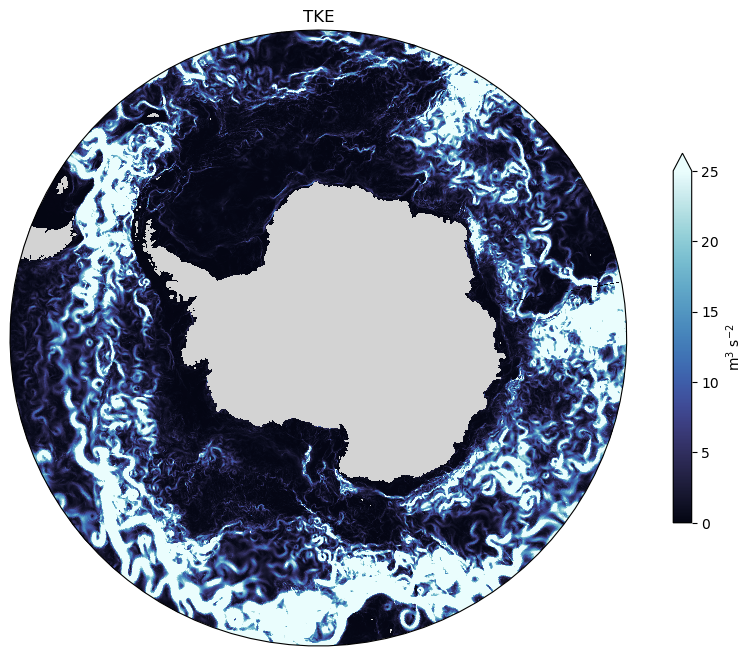

In [13]:
fig, axs = circumpolar_map()
TKE.plot(ax = axs, vmax = 25, cmap = cm.cm.ice, transform = ccrs.PlateCarree(),
         cbar_kwargs = {'label':'m$^3$ s$^{-2}$', 'shrink':0.6});
axs.set_title('TKE');

Snapshot plot of depth-integrated KE for a random time step:

In [14]:
KE_snapshot = KE_dz.isel(time = 0).sum('st_ocean')
KE_snapshot = KE_snapshot.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 180.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


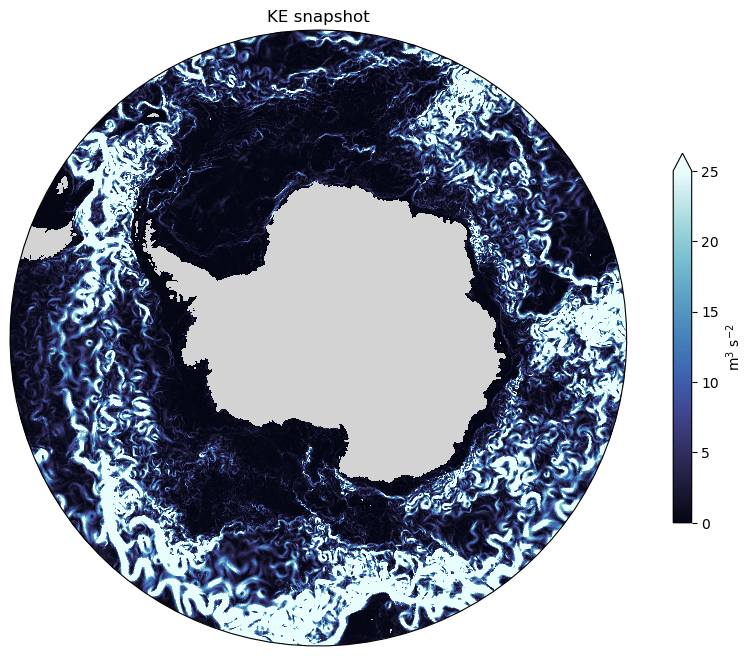

In [15]:
fig, axs = circumpolar_map()
KE_snapshot.plot(ax = axs, vmax = 25, cmap = cm.cm.ice, transform = ccrs.PlateCarree(),
                 cbar_kwargs = {'label':'m$^3$ s$^{-2}$', 'shrink':0.6});
axs.set_title('KE snapshot');

## Mean Kinetic Energy

For the mean kinetic energy, we need to average the velocities over time.

$$ {\rm MKE} = \frac{1}{2} \left( \bar{u}^2 + \bar{v}^2 \right). $$

In [16]:
u_mean = u.mean('time')
v_mean = v.mean('time')

In [17]:
MKE = (0.5*(u_mean**2 + v_mean**2)*dzu).sum('st_ocean')

In [18]:
MKE = MKE.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 174.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


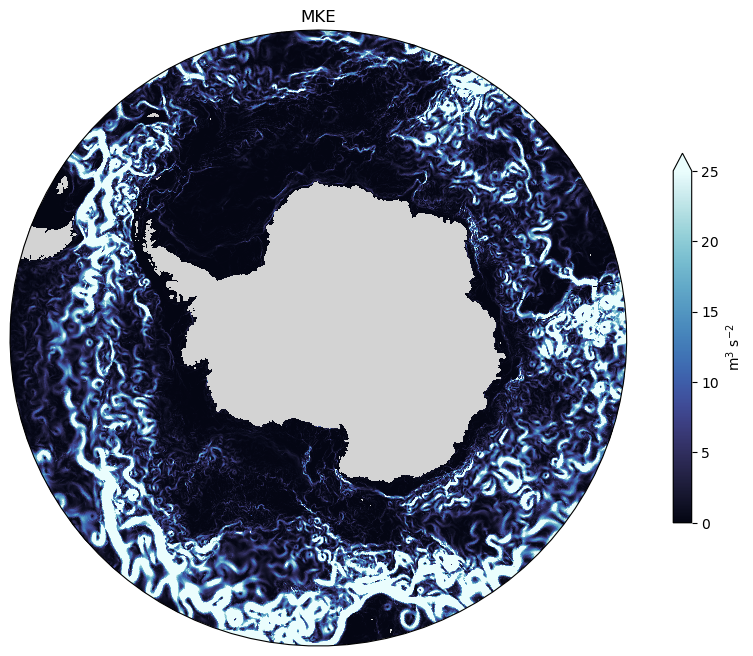

In [19]:
fig, axs = circumpolar_map()
MKE.plot(ax = axs, vmax = 25, cmap = cm.cm.ice, transform = ccrs.PlateCarree(),
         cbar_kwargs = {'label':'m$^3$ s$^{-2}$', 'shrink':0.6});
axs.set_title('MKE');

## Eddy Kinetic Energy

We calculate the transient component of the velocity field and then compute the EKE:


$$ {\rm EKE} =  \overline{ \frac{1}{2} \left[ \left(u - \overline{u}\right)^2 + \left(v - \overline{v}\right)^2 \right] }. $$

In [20]:
u_transient = u - u_mean
v_transient = v - v_mean

In [21]:
EKE = (0.5*(u_transient**2 + v_transient**2)*dzu).sum('st_ocean').mean('time')

In [22]:
EKE = EKE.load()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 183.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


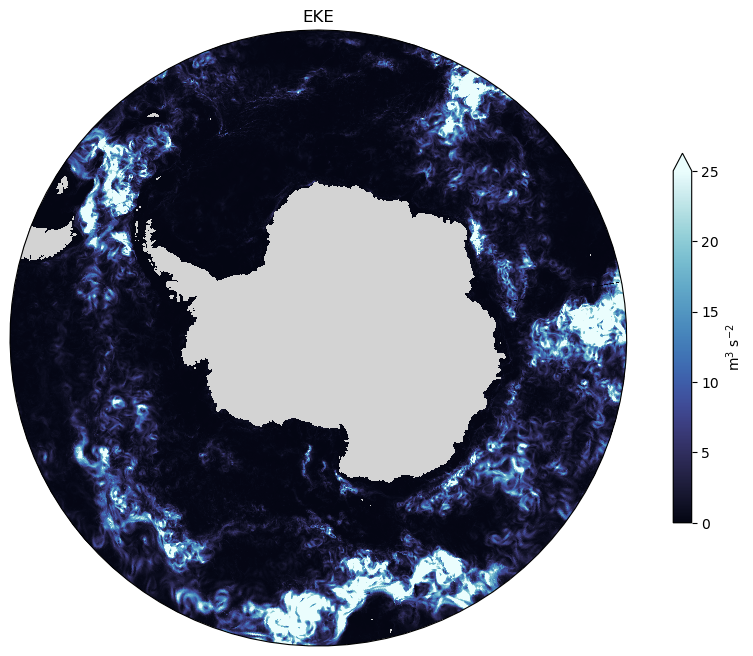

In [23]:
fig, axs = circumpolar_map()
EKE.plot(ax = axs, vmax = 25, cmap = cm.cm.ice, transform = ccrs.PlateCarree(),
         cbar_kwargs = {'label':'m$^3$ s$^{-2}$', 'shrink':0.6});
axs.set_title('EKE');